In [1]:
import numpy as np
import torch
from torch import optim
import mgplvm
from mgplvm import kernels, rdist
from mgplvm.manifolds import Torus, Euclid, So3
from mgplvm.models import Product
from mgplvm.training import train
import matplotlib.pyplot as plt
import syndata
from mgplvm.utils import get_device
torch.set_default_dtype(torch.float64)
device = get_device()
plt.rcParams.update({'font.size': 22})
np.random.seed(13332010)
torch.manual_seed(13332010)

mean activity: 0.2770466493962498


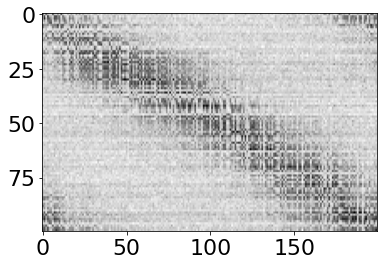

In [2]:
d = 1  # dims of latent space
n = 100  # number of neurons
m = 200  # number of conditions / time points
n_z = 10  # number of inducing points
n_samples = 1  # number of samples

#generate synthetic data
gen = syndata.Gen([syndata.Torus(d), syndata.Euclid(d)], n, m, variability=0.10, l = 0.8, beta = 0.2)
Y = gen.gen_data()
print('mean activity:', np.mean(Y))

# specify manifold, kernel and rdist for fitting
manifs = [Torus(m, d), Euclid(m, d)]
manifs = [m.to(device) for m in manifs]
ref_dists = [
    mgplvm.rdist.MVN(m, d, sigma=1.5).to(device) for i in range(len(manifs))
]
# initialize signal variance
alpha = np.mean(np.std(Y, axis=1), axis=1)
kernels = [
    kernels.QuadExp(n, manif.distance, alpha=np.sqrt(alpha)).to(device)
    for manif in manifs
]

sigma = np.mean(np.std(Y, axis=1), axis=1)  # initialize noise
mod = Product(manifs, n, m, n_z, kernels, ref_dists, device,
              sigma=sigma).to(device)

#plot raw data sorted according to the T1 component of the true manifold
plt.figure()
Yplot = Y[np.argsort(gen.gprefs[0][:, 0]), :, 0][:, np.argsort(gen.gs[0][:, 0])]
plt.imshow(Yplot, cmap='Greys', aspect='auto')
plt.show()
plt.close()

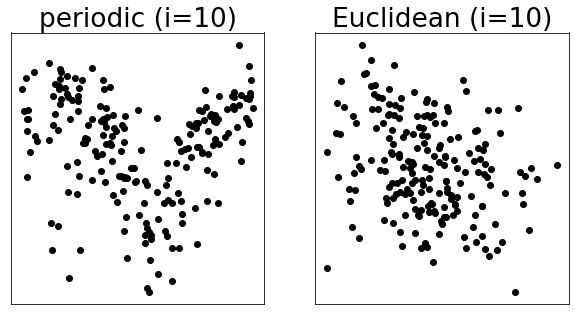

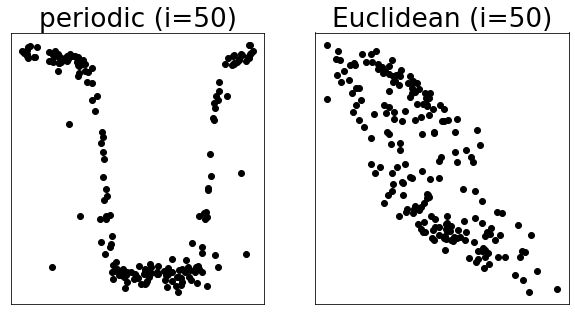

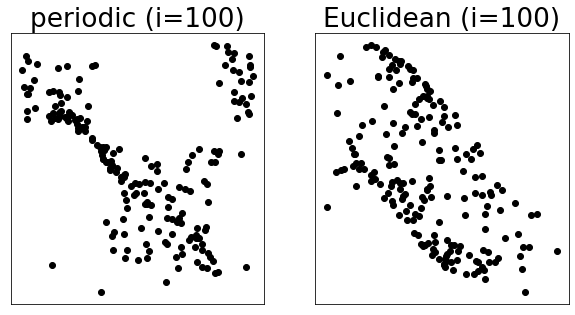

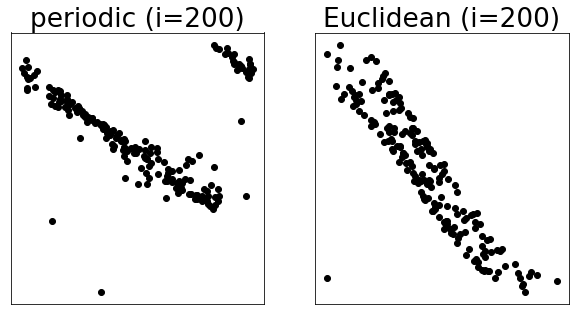

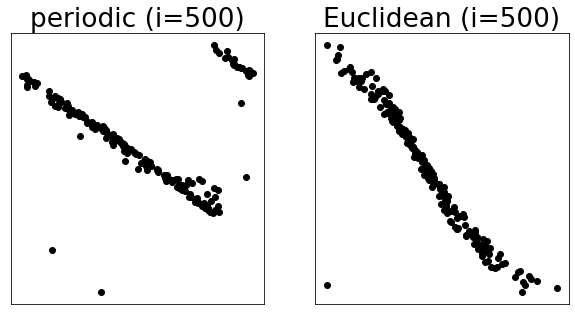

final importance weighted log likelihood: 0.5600581124165315


In [3]:
#define a function true and inferred latents at different iterations
def cb(mod, i_iter):
    if i_iter in [10, 50, 100, 200, 500, 1000]:
        g_mus = [mod.manif[i].prms.data.cpu().numpy() for i in range(2)]
        fig, axs = plt.subplots(1,2, figsize = (10, 5))
        for i in range(2):
            axs[i].plot(gen.gs[i][:,0], g_mus[i][:, 0], 'ko')
            axs[i].set_xticks([])
            axs[i].set_yticks([])
        axs[0].set_title('periodic (i='+str(i_iter)+')')
        axs[1].set_title('Euclidean (i='+str(i_iter)+')')
        plt.show()
        

# train model
trained_mod = train(Y,
                    mod,
                    device,
                    optimizer=optim.Adam,
                    callback = cb,
                    outdir='none',
                    max_steps=1000,
                    burnin='default',
                    print_every = 10,
                    n_b=128,
                    lrate=5E-2)

#compute marginal likelihood
data = torch.tensor(Y, dtype=torch.get_default_dtype()).to(device)
print('final importance weighted log likelihood:',
      mod.calc_LL(data, 128).data.cpu().numpy())
